# Clustering

In this notebook clustering is being applied to the correlation dataframe in order to group countries by similarity. The analysis will be performed for the different dimensions of the indicators: equality, socio-demographic and economic. In the end there is a global analysis  using all the indicators and giving a final conclusion to this notebook.

### Import

Import all the libraries and the correlation dataframe generated in the Notebook-Golden.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from numpy import sort
from sklearn.manifold import TSNE
import ipywidgets as widgets
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from matplotlib import gridspec
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.cluster import AffinityPropagation
from ipywidgets import interact, interact_manual
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

output_path = os.getcwd() + '/Output/'
col_country = 'Country'
col_region = 'Region'
col_year = 'Year'
col_cluster = 'Cluster'
col_1comp = '1st_component'
col_2comp = '2nd_component'

## LOADING THE DATAFRAME
We will use the Pearson Correlation Dataframe. We could use Spearman's by simply changing the name of the file to be read.

In [2]:
corr_df = pd.read_csv(output_path + 'Corr_DF_spearman.csv', index_col = col_country)
corr_df

,AgriShareGDP,CreditToAgriFishForest,EmploymentRural,% Soldiers,Employment in industry,Employment in services,Birth Rate,Cost business start-up,Death Rate,Employment in agriculture,...,Researchers in R&D,R&D expenditure %GDP,% Rural Population,Tertiary School Gender Parity,% Vulnerable female employment,% Vulnerable male employment,Civil Liberties,Freedom of Expression,% Healthcare Investment,Population
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,-0.864566,NaN,NaN,NaN,0.910685,0.911984,-0.914286,-0.736206,-0.914286,-0.910685,...,NaN,NaN,-0.914286,NaN,-0.910685,-0.910685,NaN,0.666451,NaN,0.914286
Albania,-0.486522,NaN,NaN,-0.782836,0.802469,0.766483,-0.854823,-0.767682,0.885714,-0.858720,...,NaN,NaN,-0.889610,NaN,NaN,-0.697629,0.796368,NaN,NaN,-0.888312
Algeria,NaN,NaN,NaN,-0.755527,0.853152,0.753491,0.874026,-0.725858,NaN,-0.750487,...,NaN,NaN,-0.750649,0.738578,-0.758688,NaN,0.696313,NaN,0.629927,0.750649
Angola,NaN,NaN,NaN,-0.755527,-0.648912,-0.924326,-0.753247,-0.748783,-0.753247,0.912634,...,NaN,NaN,-0.753247,NaN,0.673595,0.655408,0.744056,0.748459,NaN,0.753247
Argentina,-0.598246,0.569016,NaN,-0.733421,NaN,NaN,-0.761039,NaN,-0.761039,-0.721302,...,0.791166,0.870413,-0.761039,0.766483,NaN,-0.433907,NaN,-0.705732,NaN,0.761039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uruguay,-0.587853,0.886652,NaN,-0.934981,-0.498214,0.764133,-0.901299,-0.896356,0.619481,-0.790516,...,NaN,0.574862,-0.901299,NaN,NaN,-0.503410,NaN,NaN,0.833388,0.902597
Uzbekistan,-0.714518,NaN,NaN,-0.672302,0.916531,0.743340,0.607537,-0.847464,-0.675026,-0.745047,...,-0.794805,-0.748052,-0.836364,-0.666234,-0.828191,-0.834687,NaN,0.525872,0.925625,0.850649
Vanuatu,NaN,-0.569106,NaN,NaN,0.967197,-0.632023,-0.971429,-0.838989,-0.944120,-0.939916,...,NaN,NaN,-0.971429,NaN,-0.971095,-0.781423,0.827089,NaN,-0.813901,0.971429


## DEFINING THE GROUPS

In order to carry out a more sensitive study, we will not only study the indicators as a whole, but also separate them in the following groups to study them more in-depth.

In [3]:
econ_ind = 'Economic Indicators'
socdem_ind = 'Social-demographic Indicators'
eq_ind = 'Equality Indicators'
all_ind = 'All indicators'

ind_dict = {
    econ_ind: ['CreditToAgriFishForest', 'AgriShareGDP', 'EmploymentRural', '%EmploymentAgriFishForest', 'TotalAgri', '% Soldiers', '% Healthcare Investment', '% Employment Industry', '% Education Expenditure','R&D expenditure %GDP','Researchers in R&D','Employment in agriculture','Employment in industry','Employment in services','Cost business start-up','% Education Expenditure'],
    socdem_ind: ['Marriage Rate', 'Birth Rate', 'Death Rate', 'Homicides', 'Life Expectancy', 'Maternal Death Risk', 'Literacy Rate', 'Infant Mortality', '% Population Growth', '% Rural Population', 'Suicide Rate', 'Population'],
    eq_ind: ['Gender Equality', 'Gender Inequality','% Men Employment', '% Women Employment', 'Women Schooling Years', 'Men Schooling Years', 'Freedom of Expression', '% Undernourishment', 'Civil Liberties', 'Gini','Tertiary School Gender Parity','% Female Employment','% Male Employment','% Vulnerable male employment','% Vulnerable female employment'],
    all_ind: corr_df.columns.tolist()
}

# Keep only the ones that have been carried on to this point.

indicators = set(corr_df.columns)
for ind in ind_dict:
    ind_dict[ind] = list(set(ind_dict[ind]) & indicators)

# Divide the corr_df into slices for each group of indicators, normalize them and store them into a dict.
df_dict = {}
for ind in ind_dict:
    df_norm = corr_df.copy()
    df_norm.drop(df_norm.columns.difference(ind_dict[ind]), axis = 'columns', inplace=True)
    df_norm = df_norm.dropna(how = 'all').fillna(value = 0)
    df_norm.name = ind
    df_dict[ind] = df_norm

for ind in ind_dict:
    print(df_dict[ind].name)
    display(df_dict[ind])

Economic Indicators


,AgriShareGDP,CreditToAgriFishForest,EmploymentRural,% Soldiers,Employment in industry,Employment in services,Cost business start-up,Employment in agriculture,% Education Expenditure,Researchers in R&D,R&D expenditure %GDP,% Healthcare Investment
Country,,,,,,,,,,,,
Afghanistan,-0.864566,0.000000,0.0,0.000000,0.910685,0.911984,-0.736206,-0.910685,0.000000,0.000000,0.000000,0.000000
Albania,-0.486522,0.000000,0.0,-0.782836,0.802469,0.766483,-0.767682,-0.858720,0.000000,0.000000,0.000000,0.000000
Algeria,0.000000,0.000000,0.0,-0.755527,0.853152,0.753491,-0.725858,-0.750487,0.000000,0.000000,0.000000,0.629927
Angola,0.000000,0.000000,0.0,-0.755527,-0.648912,-0.924326,-0.748783,0.912634,0.493506,0.000000,0.000000,0.000000
Argentina,-0.598246,0.569016,0.0,-0.733421,0.000000,0.000000,0.000000,-0.721302,0.875609,0.791166,0.870413,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
Uruguay,-0.587853,0.886652,0.0,-0.934981,-0.498214,0.764133,-0.896356,-0.790516,0.000000,0.000000,0.574862,0.833388
Uzbekistan,-0.714518,0.000000,0.0,-0.672302,0.916531,0.743340,-0.847464,-0.745047,0.000000,-0.794805,-0.748052,0.925625
Vanuatu,0.000000,-0.569106,0.0,0.000000,0.967197,-0.632023,-0.838989,-0.939916,0.000000,0.000000,0.000000,-0.813901


Social-demographic Indicators


,Birth Rate,Death Rate,Homicides,Life Expectancy,Maternal Death Risk,Infant Mortality,% Population Growth,% Rural Population,Population
Country,,,,,,,,,
Afghanistan,-0.914286,-0.914286,0.000000,0.914286,-0.905542,-0.914286,0.000000,-0.914286,0.914286
Albania,-0.854823,0.885714,-0.577374,0.889610,-0.782415,-0.801430,0.000000,-0.889610,-0.888312
Algeria,0.874026,0.000000,0.000000,0.750649,0.000000,-0.750649,0.797403,-0.750649,0.750649
Angola,-0.753247,-0.753247,0.000000,0.753247,-0.776551,-0.753247,0.000000,-0.753247,0.753247
Argentina,-0.761039,-0.761039,0.000000,0.761039,-0.784369,-0.761039,0.000000,-0.761039,0.761039
...,...,...,...,...,...,...,...,...,...
Uruguay,-0.901299,0.619481,0.764630,0.901299,-0.848213,-0.901299,0.901299,-0.901299,0.902597
Uzbekistan,0.607537,-0.675026,0.000000,0.850649,-0.812382,-0.850649,0.759740,-0.836364,0.850649
Vanuatu,-0.971429,-0.944120,0.000000,0.971429,-0.975901,0.000000,0.000000,-0.971429,0.971429


Equality Indicators


,% Female Employment,% Male Employment,Tertiary School Gender Parity,% Vulnerable female employment,% Vulnerable male employment,Civil Liberties,Freedom of Expression
Country,,,,,,,
Afghanistan,0.732468,-0.705653,0.000000,-0.910685,-0.910685,0.000000,0.666451
Albania,0.000000,0.000000,0.000000,0.000000,-0.697629,0.796368,0.000000
Algeria,0.814286,0.542857,0.738578,-0.758688,0.000000,0.696313,0.000000
Angola,-0.514453,-0.659305,0.000000,0.673595,0.655408,0.744056,0.748459
Argentina,0.477922,0.000000,0.766483,0.000000,-0.433907,0.000000,-0.705732
...,...,...,...,...,...,...,...
Uruguay,0.814286,0.496104,0.000000,0.000000,-0.503410,0.000000,0.000000
Uzbekistan,-0.785714,-0.612987,-0.666234,-0.828191,-0.834687,0.000000,0.525872
Vanuatu,0.000000,0.000000,0.000000,-0.971095,-0.781423,0.827089,0.000000


All indicators


,AgriShareGDP,CreditToAgriFishForest,EmploymentRural,% Soldiers,Employment in industry,Employment in services,Birth Rate,Cost business start-up,Death Rate,Employment in agriculture,...,Researchers in R&D,R&D expenditure %GDP,% Rural Population,Tertiary School Gender Parity,% Vulnerable female employment,% Vulnerable male employment,Civil Liberties,Freedom of Expression,% Healthcare Investment,Population
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,-0.864566,0.000000,0.0,0.000000,0.910685,0.911984,-0.914286,-0.736206,-0.914286,-0.910685,...,0.000000,0.000000,-0.914286,0.000000,-0.910685,-0.910685,0.000000,0.666451,0.000000,0.914286
Albania,-0.486522,0.000000,0.0,-0.782836,0.802469,0.766483,-0.854823,-0.767682,0.885714,-0.858720,...,0.000000,0.000000,-0.889610,0.000000,0.000000,-0.697629,0.796368,0.000000,0.000000,-0.888312
Algeria,0.000000,0.000000,0.0,-0.755527,0.853152,0.753491,0.874026,-0.725858,0.000000,-0.750487,...,0.000000,0.000000,-0.750649,0.738578,-0.758688,0.000000,0.696313,0.000000,0.629927,0.750649
Angola,0.000000,0.000000,0.0,-0.755527,-0.648912,-0.924326,-0.753247,-0.748783,-0.753247,0.912634,...,0.000000,0.000000,-0.753247,0.000000,0.673595,0.655408,0.744056,0.748459,0.000000,0.753247
Argentina,-0.598246,0.569016,0.0,-0.733421,0.000000,0.000000,-0.761039,0.000000,-0.761039,-0.721302,...,0.791166,0.870413,-0.761039,0.766483,0.000000,-0.433907,0.000000,-0.705732,0.000000,0.761039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uruguay,-0.587853,0.886652,0.0,-0.934981,-0.498214,0.764133,-0.901299,-0.896356,0.619481,-0.790516,...,0.000000,0.574862,-0.901299,0.000000,0.000000,-0.503410,0.000000,0.000000,0.833388,0.902597
Uzbekistan,-0.714518,0.000000,0.0,-0.672302,0.916531,0.743340,0.607537,-0.847464,-0.675026,-0.745047,...,-0.794805,-0.748052,-0.836364,-0.666234,-0.828191,-0.834687,0.000000,0.525872,0.925625,0.850649
Vanuatu,0.000000,-0.569106,0.0,0.000000,0.967197,-0.632023,-0.971429,-0.838989,-0.944120,-0.939916,...,0.000000,0.000000,-0.971429,0.000000,-0.971095,-0.781423,0.827089,0.000000,-0.813901,0.971429


## t-SNE

The algorithm of t-SNE (t-Distributed Stochastic Neighbor Embedding) is used to reduce the dimensionality of all the indicators to only 2 components. It admits a number of parameters to tune the procedure and obtain an optimal output: 
- N-components: the dimensions to analyze.
- Perplexity: measurement of how well a probability distribution or probability model predicts a sample.
- N-iter: iterations for the optimization
- Learning rate: how fast the algorithm learns. A high value may cause a ball form of the data.
- Init: Initialization of embedding. 'pca' is the new default for newer versions.

In this cell, we define the different values that will be used for each group of indicators.

In [4]:
# The TSNE algorithm admits a number of parameters
tsne_dict = {
    econ_ind: TSNE(n_components = 2, perplexity = 5, n_iter = 50000, learning_rate = 100.0, init = 'pca'),
    socdem_ind: TSNE(n_components = 2, perplexity = 5, n_iter = 50000, learning_rate = 100.0, init = 'pca'),
    eq_ind: TSNE(n_components = 2, perplexity = 5, n_iter = 50000, learning_rate = 100.0, init = 'pca'),
    all_ind: TSNE(n_components = 2, perplexity = 5, n_iter = 50000, learning_rate = 100.0, init = 'pca')
}

## CLUSTERING

### Affinity Propagation

The clustering method used in the notebook is Affinity Propagation. The reason behind choosing this one is because it is suited for our data: many clusters with uneven cluster size; also, it can simply be optmized changing 1 parameter, "damping". 
- Damping: is the extent to which the current value is maintained relative to incoming values (weighted 1 - damping).

Again, in this cell we will calibrate the clustering algorithm for each indicator group.

In [5]:
afprop_dict = {
    econ_ind: AffinityPropagation(damping=0.5),
    socdem_ind: AffinityPropagation(damping=0.5),
    eq_ind: AffinityPropagation(damping=0.5),
    all_ind: AffinityPropagation(damping=0.5)
}

In [6]:


for ind in ind_dict:
    df_norm = df_dict[ind]

    # Apply the TSNE chosen for that indicator
    df_tsne = pd.DataFrame(tsne_dict[ind].fit_transform(df_norm))

    # Scale the result
    scaled_df = pd.DataFrame(StandardScaler().fit_transform(df_tsne), index = df_norm.index, columns = [col_1comp, col_2comp])
    
    # Apply Affinity Propagation
    affinity = afprop_dict[ind].fit(scaled_df)

    # Update the DataFrame with the resulting Cluster labels
    labels_affinity = affinity.labels_
    df_dict[ind].loc[:, col_cluster] = labels_affinity
    scaled_df[col_cluster] = labels_affinity
    scaled_df[col_cluster] = scaled_df[col_cluster].astype(str)

    # Show the resulting chart
    fig = px.scatter(scaled_df, x = col_1comp, y = col_2comp, text = scaled_df.index, size_max=100, color=col_cluster, category_orders={col_cluster: sort(list(set(scaled_df.loc[:, col_cluster])))})
    fig.update_layout(title_text=ind, title_x=0.5)
    fig.update_traces(textposition='top center')
    fig.show()

## Widget Clustering

In order to explore the clustering results given a country, we can choose that country and the group of indicators in the table below, to see what other countries are in the same cluster for the selected group of indicators.

In [7]:
def tableCountry(Ind, Country):
    try:
        # Find the cluster Country belongs to.
        cluster_number = df_dict[Ind].loc[df_dict[Ind].index == Country, col_cluster].item()

        # Retrieve the Dataframe with the selected indicators, and filter to only show the rows (countries) belonging to the cluster. Drop the cluster number column as it is redundant.
        df_ind = df_dict[Ind]
        df = df_ind.loc[df_ind[col_cluster] == cluster_number].drop(col_cluster, axis = 'columns')

        # Format the Dataframe representation.
        df_s = df.style
        df_s.apply_index(lambda i: ['background-color: #aadfff; font-weight: 500' if c == Country else '' for c in i], axis = 0)
        df_s.apply(lambda row: ['background-color: #ccebff;' if row.name == Country else '' for cell in row], axis = 1)
        df_s.set_table_styles([{'selector': 'td:hover', 'props': [('background-color', '#ddfdff')]}])
        tt = {}
        for col in df.columns:
            tt[col] = 'Column median: ' + str(df.loc[:, col].median())
        df_s.set_tooltips(pd.DataFrame(tt, index = df.index))

        # Display a short descriptive title and the Dataframe.
        display(Country + ' belongs to Cluster ' + str(cluster_number) + '. This Cluster contains a total of ' + str(df.shape[0]) + ' countries.')
        display(df_s)
    except Exception:
        return print('No indicators available for this country.')

@interact(
    Indicators = df_dict.keys(),
    Country = sort(corr_df.index.tolist()))

def g(Indicators = 'Equality indicators', Country = 'Afghanistan'):
    return tableCountry(Indicators, Country)

interactive(children=(Dropdown(description='Indicators', options=('Economic Indicators', 'Social-demographic I…

### SAVING CLUSTERING RESULTS

We now write a .csv file for each group of indicators and the clusters each countries belongs to. By default, we sort the rows by cluster.

In [8]:
cluster_folder = os.getcwd() + '/Output/Cluster/'

if not os.path.exists(cluster_folder):
            os.makedirs(cluster_folder)

for ind in ind_dict:
    print(ind)
    df = df_dict[ind]
    df = df.set_index(['Cluster', df.index]).sort_index()
    df.to_csv(cluster_folder + ind + '.csv')
    display(df)


Economic Indicators


AgriShareGDP  CreditToAgriFishForest  EmploymentRural  \
Cluster Country                                                             
0       Argentina      -0.598246                0.569016              0.0   
        Brazil         -0.716466                0.000000              0.0   
        China           0.000000                0.000000              0.0   
        Cyprus         -0.564469                0.000000              0.0   
        Djibouti       -0.716050                0.000000              0.0   
...                          ...                     ...              ...   
9       Seychelles     -0.789217                0.000000              0.0   
        Suriname       -0.894446                0.000000              0.0   
        Uganda         -0.576161                0.000000              0.0   
        Vanuatu         0.000000               -0.569106              0.0   
        Zimbabwe       -0.669698                0.000000              0.0   

                    % Soldiers  Employment in industry  \
Cluster Country                                          
0       Argentina    -0.733421                0.000000   
        Brazil       -0.681405                0.000000   
        China        -0.881665                0.710202   
        Cyprus        0.000000                0.000000   
        Djibouti     -0.964890                0.000000   
...                        ...                     ...   
9       Seychelles    0.000000                0.000000   
        Suriname     -0.526658                0.557868   
        Uganda       -0.921977               -0.531687   
        Vanuatu       0.000000                0.967197   
        Zimbabwe     -0.841353               -0.782722   

                    Employment in services  Cost business start-up  \
Cluster Country                                                      
0       Argentina                 0.000000                0.000000   
        Brazil                    0.687886                0.000000   
        China                     0.999675                0.000000   
        Cyprus                    0.470283                0.000000   
        Djibouti                  0.999675                0.000000   
...                                    ...                     ...   
9       Seychelles                0.000000                0.000000   
        Suriname                 -0.492528                0.000000   
        Uganda                    0.000000               -0.914310   
        Vanuatu                  -0.632023               -0.838989   
        Zimbabwe                  0.000000               -0.884333   

                    Employment in agriculture  % Education Expenditure  \
Cluster Country                                                          
0       Argentina                   -0.721302                 0.875609   
        Brazil                      -0.691783                 0.734721   
        China                       -0.998375                 0.680731   
        Cyprus                      -0.691134                 0.536811   
        Djibouti                    -0.999675                 0.000000   
...                                       ...                      ...   
9       Seychelles                   0.000000                 0.000000   
        Suriname                     0.000000                 0.000000   
        Uganda                       0.000000                -0.650649   
        Vanuatu                     -0.939916                 0.000000   
        Zimbabwe                     0.563170                 0.000000   

                    Researchers in R&D  R&D expenditure %GDP  \
Cluster Country                                                
0       Argentina             0.791166              0.870413   
        Brazil                0.000000              0.676194   
        China                 0.936364              1.000000   
        Cyprus                0.754545              0.601494   
     

Social-demographic Indicators


Birth Rate  Death Rate  Homicides  Life Expectancy  \
Cluster Country                                                            
0       Bangladesh     -0.998701   -0.998701  -0.434331         0.998701   
        Benin          -0.990909   -0.990909   0.000000         0.990909   
        Guatemala      -0.998701   -0.998701  -0.435631         0.998701   
        Haiti          -0.938961   -0.938961   0.000000         0.938961   
        Honduras       -0.994805   -0.920779   0.000000         0.994805   
...                          ...         ...        ...              ...   
9       Sweden          0.526424   -0.814575   0.000000         0.828571   
        Tajikistan      0.572727   -0.909091   0.000000         0.909091   
        Tunisia         0.827273    0.808055   0.000000         0.596104   
        Turkmenistan    0.000000   -0.951948   0.000000         0.950649   
        Uzbekistan      0.607537   -0.675026   0.000000         0.850649   

                      Maternal Death Risk  Infant Mortality  \
Cluster Country                                               
0       Bangladesh              -0.995445         -0.998701   
        Benin                   -0.987627         -0.990909   
        Guatemala               -0.996748         -0.998701   
        Haiti                   -0.898376         -0.938961   
        Honduras                -0.995445         -0.994805   
...                                   ...               ...   
9       Sweden                  -0.493162         -0.810306   
        Tajikistan              -0.905542         -0.909091   
        Tunisia                  0.000000         -0.596491   
        Turkmenistan            -0.940722         -0.927435   
        Uzbekistan              -0.812382         -0.850649   

                      % Population Growth  % Rural Population  Population  
Cluster Country                                                            
0       Bangladesh              -0.941558           -0.998701    0.998701  
        Benin                   -0.974026           -0.990909    0.990909  
        Guatemala               -0.998701           -0.998701    0.998701  
        Haiti                   -0.938961           -0.938961    0.938961  
        Honduras                -0.994805           -0.994805    0.994805  
...                                   ...                 ...         ...  
9       Sweden                   0.677922           -0.815584    0.815584  
        Tajikistan               0.889610           -0.909091    0.909091  
        Tunisia                  0.000000           -0.596104    0.596104  
        Turkmenistan             0.825974           -0.950649    0.950649  
        Uzbekistan               0.759740           -0.836364    0.850649  

[153 rows x 9 columns]

Equality Indicators


% Female Employment  % Male Employment  \
Cluster Country                                                          
0       Australia                          0.736364           0.000000   
        Bahrain                            0.897403           0.000000   
        Bosnia and Herzegovina             0.736021           0.000000   
        Bulgaria                           0.844156           0.810390   
        Dominican Republic                 0.964935           0.000000   
...                                             ...                ...   
8       Saudi Arabia                       0.838752           0.862338   
        Solomon Islands                    0.000000           0.745455   
        Togo                               0.816883           0.000000   
        Tunisia                            0.000000           0.000000   
        Vanuatu                            0.000000           0.000000   

                                Tertiary School Gender Parity  \
Cluster Country                                                 
0       Australia                                    0.000000   
        Bahrain                                      0.000000   
        Bosnia and Herzegovina                       0.000000   
        Bulgaria                                     0.000000   
        Dominican Republic                           0.000000   
...                                                       ...   
8       Saudi Arabia                                -0.793506   
        Solomon Islands                              0.000000   
        Togo                                         0.000000   
        Tunisia                                      0.594805   
        Vanuatu                                      0.000000   

                                % Vulnerable female employment  \
Cluster Country                                                  
0       Australia                                    -0.806755   
        Bahrain                                       0.000000   
        Bosnia and Herzegovina                       -0.591101   
        Bulgaria                                     -0.877193   
        Dominican Republic                            0.000000   
...                                                        ...   
8       Saudi Arabia                                 -0.707373   
        Solomon Islands                              -0.978889   
        Togo                                         -0.819747   
        Tunisia                                      -0.565768   
        Vanuatu                                      -0.971095   

                                % Vulnerable male employment  Civil Liberties  \
Cluster Country                                                                 
0       Australia                                  -0.852502        -0.745732   
        Bahrain                                    -0.769331        -0.828779   
        Bosnia and Herzegovina                     -0.839234         0.000000   
        Bulgaria                                   -0.847678        -0.692060   
        Dominican Republic                          0.000000        -0.809713   
...                                                      ...              ...   
8       Saudi Arabia                               -0.923027         0.747887   
        Solomon Islands                            -0.978889         0.567749   
        Togo                                       -0.987334         0.719680   
        Tunisia                                    -0.486522         0.584261   
        Vanuatu                                    -0.781423         0.827089   

                                Freedom of Expression  
Cluster Country                                        
0       Australia                           -0.661451  
        Bahrain                             -0.752287  
        Bosnia and Herzegovina              -0.859690  
        Bulgaria              

All indicators


AgriShareGDP  CreditToAgriFishForest  EmploymentRural  \
Cluster Country                                                                 
0       Bahrain            -0.563170               -0.732056         0.000000   
        Kuwait              0.000000                0.000000         0.000000   
        Oman                0.000000               -0.540611         0.000000   
        Panama             -0.990581                0.984066         0.000000   
        Qatar              -0.594349                0.000000         0.000000   
...                              ...                     ...              ...   
11      Netherlands        -0.865866                0.000000         0.000000   
        New Zealand         0.000000                0.000000         0.000000   
        Slovenia           -0.628126                0.000000        -0.758671   
        United Kingdom     -0.548943                0.000000         0.000000   
        Zimbabwe           -0.669698                0.000000         0.000000   

                        % Soldiers  Employment in industry  \
Cluster Country                                              
0       Bahrain          -0.983096                0.893147   
        Kuwait           -0.625488                0.785320   
        Oman             -0.875163                0.829490   
        Panama            0.000000                0.500812   
        Qatar            -0.892068                0.533290   
...                            ...                     ...   
11      Netherlands      -0.686607               -0.745939   
        New Zealand      -0.928479               -0.923027   
        Slovenia         -0.435631               -0.574212   
        United Kingdom   -0.785156               -0.658212   
        Zimbabwe         -0.841353               -0.782722   

                        Employment in services  Birth Rate  \
Cluster Country                                              
0       Bahrain                      -0.846379   -0.979221   
        Kuwait                       -0.673814   -0.655844   
        Oman                         -0.786619   -0.874432   
        Panama                        0.000000   -0.980519   
        Qatar                        -0.534589   -0.836364   
...                                        ...         ...   
11      Netherlands                   0.736842   -0.722367   
        New Zealand                   0.950309   -0.727273   
        Slovenia                      0.679441    0.550132   
        United Kingdom                0.654309    0.000000   
        Zimbabwe                      0.000000    0.000000   

                        Cost business start-up  Death Rate  \
Cluster Country                                              
0       Bahrain                       0.000000   -0.565854   
        Kuwait                       -0.524737   -0.522277   
        Oman                         -0.829869   -0.863636   
        Panama                       -0.979478    0.980519   
        Qatar                         0.000000   -0.924675   
...                                        ...         ...   
11      Netherlands                  -0.721412    0.000000   
        New Zealand                   0.000000    0.000000   
        Slovenia                     -0.753553    0.000000   
        United Kingdom               -0.617726    0.000000   
        Zimbabwe                     -0.884333   -0.905195   

                        Employment in agriculture  ...  Researchers in R&D  \
Cluster Country                                    ...                       
0       Bahrain                         -0.964511  ...            0.000000   
        Kuwait                          -0.473684  ...            0.000000   
        Oman                            -0.673595  ...            0.000000   
        Panama                          -0.707373  ...            0.000000   
        Qatar                           -0.756581  ...            0.000000   
...

## VENN DIAGRAM

Finally as a more visual way to represent the clustering, we show a Venn diagram for any given country so we can observe all the countries that are related to it based on the different indicators group.

NOTE: the central intersection does not correspond to the all indicators clustering, as they have obtained by different methods. The intersection is more restrictive and contains fewer countries than the all indicators group.

In [9]:
def VennOut(Country):
    try:
        set_econ = set(df_dict[econ_ind].loc[lambda df: df[col_cluster] == df.loc[Country, col_cluster]].index.to_list())
        set_socdem = set(df_dict[socdem_ind].loc[lambda df: df[col_cluster] == df.loc[Country, col_cluster]].index.to_list())
        set_eq = set(df_dict[eq_ind].loc[lambda df: df[col_cluster] == df.loc[Country, col_cluster]].index.to_list())

        venn = venn3([set_econ, set_socdem, set_eq], (econ_ind, socdem_ind, eq_ind))

        venn.get_label_by_id('100').set_text('\n'.join(set_econ - set_socdem - set_eq)) # Only econ
        venn.get_label_by_id('010').set_text('\n'.join(set_socdem - set_econ - set_eq)) # Only socdem
        venn.get_label_by_id('001').set_text('\n'.join(set_eq - set_econ - set_socdem)) # Only eq

        # The three pair-intersections is guaranteed only if there is an intersection of the three groups.
        if len(set_econ & set_socdem & set_eq):
            venn.get_label_by_id('111').set_text('\n'.join(set_econ & set_socdem & set_eq))
            venn.get_label_by_id('110').set_text('\n'.join(set_econ & set_socdem - set_eq))
            venn.get_label_by_id('101').set_text('\n'.join(set_econ & set_eq - set_socdem))
            venn.get_label_by_id('011').set_text('\n'.join(set_socdem & set_eq - set_econ))
        else:
            # If no center, check the intersections that do exist.
            if len(set_econ & set_socdem - set_eq):
                venn.get_label_by_id('110').set_text('\n'.join(set_econ & set_socdem - set_eq))
            if len(set_econ & set_eq - set_socdem):
                venn.get_label_by_id('101').set_text('\n'.join(set_econ & set_eq - set_socdem))
            if len(set_socdem & set_eq - set_econ):
                venn.get_label_by_id('011').set_text('\n'.join(set_socdem & set_eq - set_econ))

        plt.rcParams["figure.figsize"] = (12, 12)
        plt.show()

    except:
        return print('No indicators available for this country.')


@interact(
    Country = sort(corr_df.index.tolist()))

def g(Country = 'Spain'):
    return VennOut(Country)

interactive(children=(Dropdown(description='Country', index=132, options=('Afghanistan', 'Albania', 'Algeria',…

In [10]:
scaled_df

,1st_component,2nd_component,Cluster
Country,,,
Afghanistan,0.833439,0.550632,4
Albania,-1.163139,-1.581239,10
Algeria,-1.404288,-0.066325,8
Angola,-0.166910,-0.230723,11
Argentina,-0.832337,0.440795,9
...,...,...,...
Uruguay,0.282332,-0.786911,2
Uzbekistan,1.239221,0.292323,5
Vanuatu,0.819277,0.187755,7


# Different CLustering Methods

We have tried a lot of different clustering methods in order to decide which one fits the best. Below are all the different codeblocks, each one for a different algorithm.

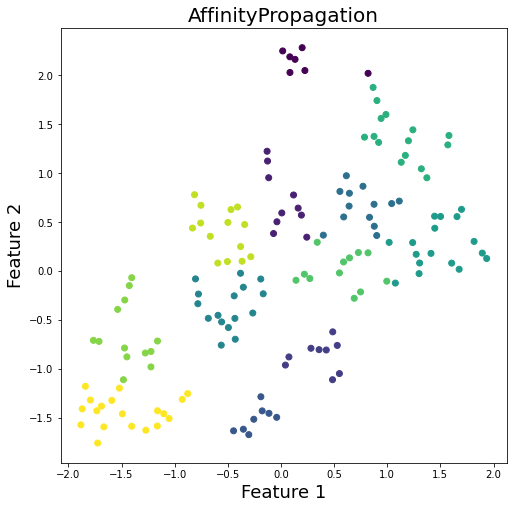

In [11]:
X_optics = pd.DataFrame(StandardScaler().fit_transform(scaled_df))

'''Apply AffinityPropagation'''
optics = AffinityPropagation(damping=0.9).fit_predict(X_optics)
#labels_optics = optics.labels_

plt.figure(figsize=(8,8))
plt.title('AffinityPropagation',fontsize= 20)
plt.xlabel('Feature 1',fontsize= 18)
plt.ylabel('Feature 2',fontsize= 18)
fig = plt.scatter(X_optics[0], X_optics[1], c= optics)

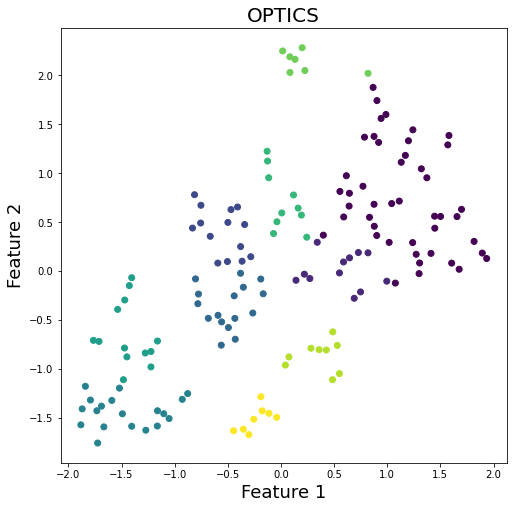

In [12]:

X_optics = pd.DataFrame(StandardScaler().fit_transform(scaled_df))

'''Apply OPTICS'''
optics = OPTICS(xi=.35, min_cluster_size=3, min_samples=5).fit_predict(X_optics)
#labels_optics = optics.labels_

plt.figure(figsize=(8,8))
plt.title('OPTICS',fontsize= 20)
plt.xlabel('Feature 1',fontsize= 18)
plt.ylabel('Feature 2',fontsize= 18)
fig = plt.scatter(X_optics[0], X_optics[1], c= optics)


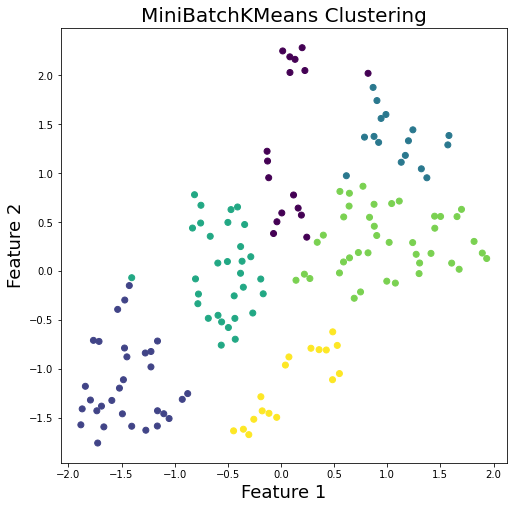

In [13]:
from sklearn.cluster import *
from sklearn.mixture import GaussianMixture

X_kmeans = pd.DataFrame(StandardScaler().fit_transform(scaled_df))
X_kmeans.index = scaled_df.index
'''Apply MiniBatchKMeans'''
kmean_clusters =   MiniBatchKMeans(n_clusters=6).fit_predict(X_kmeans)

plt.figure(figsize = (8,8))
plt.title('MiniBatchKMeans Clustering',fontsize= 20)
plt.xlabel('Feature 1', fontsize=18)
plt.ylabel('Feature 2', fontsize=18)
f = plt.scatter(X_kmeans[0],X_kmeans[1],c=kmean_clusters)

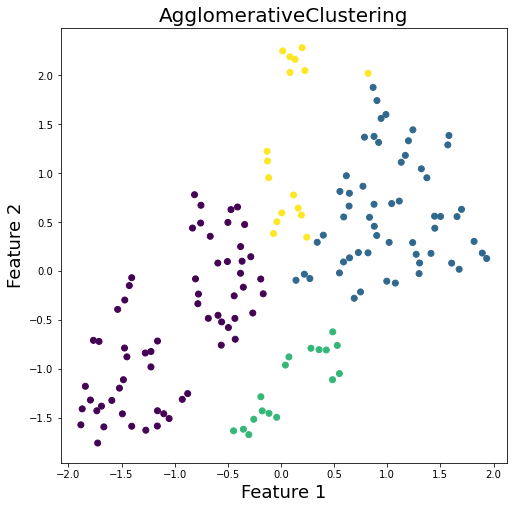

In [14]:
X_optics = pd.DataFrame(StandardScaler().fit_transform(scaled_df))

'''Apply AgglomerativeClustering'''
optics = AgglomerativeClustering(n_clusters=4).fit_predict(X_optics)
#labels_optics = optics.labels_

plt.figure(figsize=(8,8))
plt.title('AgglomerativeClustering',fontsize= 20)
plt.xlabel('Feature 1',fontsize= 18)
plt.ylabel('Feature 2',fontsize= 18)
fig = plt.scatter(X_optics[0], X_optics[1], c= optics)

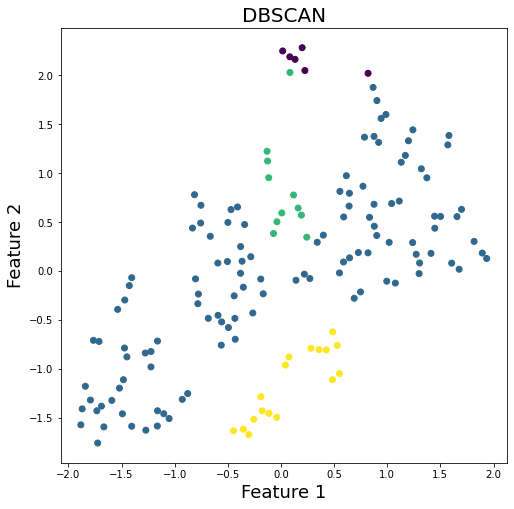

In [15]:
X_optics = pd.DataFrame(StandardScaler().fit_transform(scaled_df))

'''Apply DBSCAN'''
optics = DBSCAN(eps=0.9, min_samples=9).fit_predict(X_optics)
#labels_optics = optics.labels_

plt.figure(figsize=(8,8))
plt.title('DBSCAN',fontsize= 20)
plt.xlabel('Feature 1',fontsize= 18)
plt.ylabel('Feature 2',fontsize= 18)
fig = plt.scatter(X_optics[0], X_optics[1], c= optics)

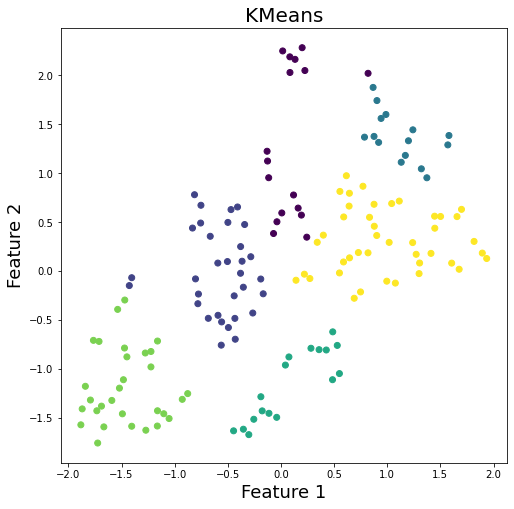

In [16]:
X_optics = pd.DataFrame(StandardScaler().fit_transform(scaled_df))

'''Apply KMeans'''
optics = KMeans(n_clusters=6).fit_predict(X_optics)
#labels_optics = optics.labels_

plt.figure(figsize=(8,8))
plt.title('KMeans',fontsize= 20)
plt.xlabel('Feature 1',fontsize= 18)
plt.ylabel('Feature 2',fontsize= 18)
fig = plt.scatter(X_optics[0], X_optics[1], c= optics)

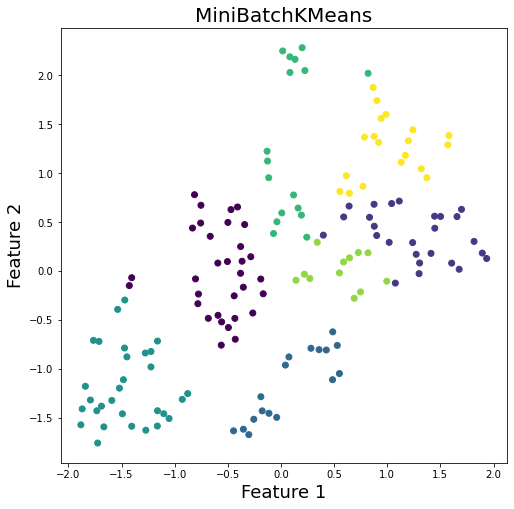

In [17]:
X_optics = pd.DataFrame(StandardScaler().fit_transform(scaled_df))

'''Apply MiniBatchKMeans'''
optics = MiniBatchKMeans(n_clusters=7).fit_predict(X_optics)
#labels_optics = optics.labels_

plt.figure(figsize=(8,8))
plt.title('MiniBatchKMeans',fontsize= 20)
plt.xlabel('Feature 1',fontsize= 18)
plt.ylabel('Feature 2',fontsize= 18)
fig = plt.scatter(X_optics[0], X_optics[1], c= optics)


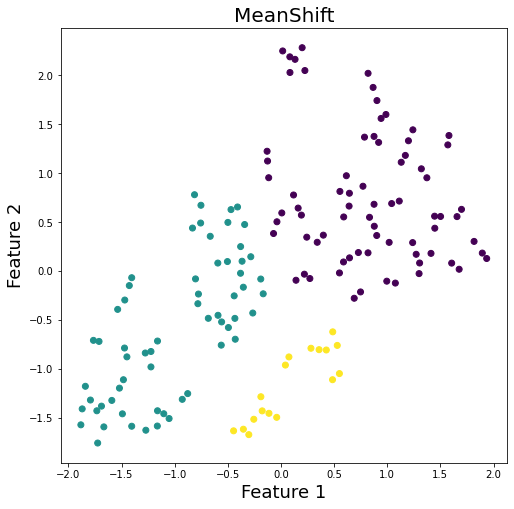

In [18]:
X_optics = pd.DataFrame(StandardScaler().fit_transform(scaled_df))

'''Apply MeanShift'''
optics = MeanShift().fit_predict(X_optics)
#labels_optics = optics.labels_

plt.figure(figsize=(8,8))
plt.title('MeanShift',fontsize= 20)
plt.xlabel('Feature 1',fontsize= 18)
plt.ylabel('Feature 2',fontsize= 18)
fig = plt.scatter(X_optics[0], X_optics[1], c= optics)


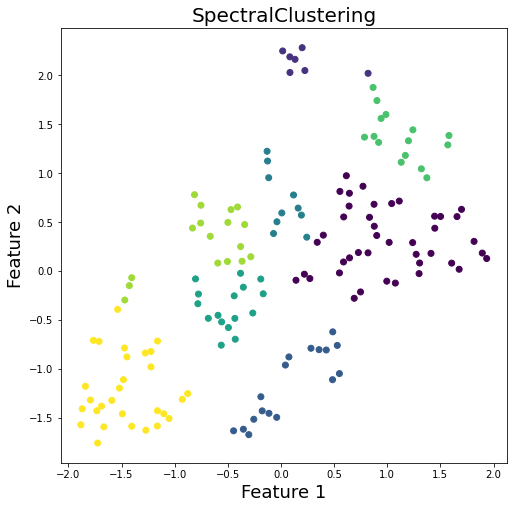

In [19]:


X_optics = pd.DataFrame(StandardScaler().fit_transform(scaled_df))

'''Apply SpectralClustering'''
optics = SpectralClustering(n_clusters=8).fit_predict(X_optics)
#labels_optics = optics.labels_

plt.figure(figsize=(8,8))
plt.title('SpectralClustering',fontsize= 20)
plt.xlabel('Feature 1',fontsize= 18)
plt.ylabel('Feature 2',fontsize= 18)
fig = plt.scatter(X_optics[0], X_optics[1], c= optics)

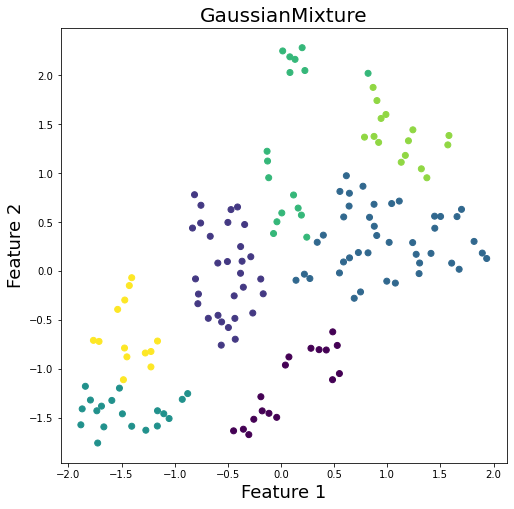

In [20]:
X_optics = pd.DataFrame(StandardScaler().fit_transform(scaled_df))

'''Apply GaussianMixture'''
optics = GaussianMixture(n_components=7).fit_predict(X_optics)
#labels_optics = optics.labels_

plt.figure(figsize=(8,8))
plt.title('GaussianMixture',fontsize= 20)
plt.xlabel('Feature 1',fontsize= 18)
plt.ylabel('Feature 2',fontsize= 18)
fig = plt.scatter(X_optics[0], X_optics[1], c= optics)